## Load Required Packages & Tools...



In [ ]:
import nltk
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics

In [ ]:
wdir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing'
out_dir = '/content/drive/MyDrive/BMI_6330-Natural_Language_Processing/heuristic_model/output_data/'

In [ ]:
#!pip install mendelai-brat-parser
#from brat_parser import get_entities_relations_attributes_groups

## Read in Training/Test Datasets & View Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv(wdir+"/TRAIN.csv")
test = pd.read_csv(wdir+"/TEST.csv")

train.drop(labels="Unnamed: 0",axis=1, inplace=True)
test.drop(labels="Unnamed: 0",axis=1, inplace=True)

print('Number of Posts in Training Set: ' + str(len(train)) + " + Number of Posts in Test Set: " + str(len(test)))

Mounted at /content/drive
Number of Posts in Training Set: 1600 + Number of Posts in Test Set: 401


In [ ]:
train.head()

,ID,text,Non_Medical_Use,Withdrawl,Tolerance,Entities,Class,Start,End
0,TN_401,this might seem like a silly post - but i've o...,0,0,0,"{'T1': Entity(id='T1', type='ADHD', span=((499...","['ADHD', 'Prescription_Stimulants', 'Prescript...","[499, 58, 879]","[503, 62, 883]"
1,TN_402,i've been off of it for over 3 years (personal...,1,0,0,"{'T1': Entity(id='T1', type='Adderall', span=(...",['Adderall'],[289],[292]
2,TN_403,i’m so confused! please has anyone felt this? ...,0,1,0,{},[],[],[]
3,TN_404,"i’m on 5mg, but will take 10mg when needed in ...",0,0,0,"{'T1': Entity(id='T1', type='Anxiety', span=((...","['Anxiety', 'Adderall', 'Anxiety', 'ADHD']","[85, 104, 401, 977]","[92, 112, 408, 980]"
4,TN_405,"hey all,so i recently got diagnosed with adhd ...",0,0,0,"{'T1': Entity(id='T1', type='ADHD', span=((41,...","['ADHD', 'Adderall']","[41, 65]","[45, 73]"


In [ ]:
test.head()

,ID,text,Non_Medical_Use,Withdrawl,Tolerance,Entities,Class,Start,End
0,TN_0,i have one pill left. i should have gone last ...,0,0,0,{},[],[],[]
1,TN_1,my health insurance doesn't really do anything...,0,0,0,{},[],[],[]
2,TN_2,i’ve been sick for a week so the next time i t...,0,0,1,"{'T1': Entity(id='T1', type='ADHD', span=((71,...","['ADHD', 'Vyvanse']","[71, 246]","[75, 253]"
3,TN_3,so i’m going to the doctors monday because i’v...,0,0,0,"{'T1': Entity(id='T1', type='Adderall', span=(...","['Adderall', 'Adderall']","[213, 413]","[221, 421]"
4,TN_4,hi guys thanks for taking the time to read thi...,1,0,0,"{'T1': Entity(id='T1', type='Adderall', span=(...","['Adderall', 'ADHD', 'Adderall', 'Marijuana', ...","[133, 148, 272, 508, 522]","[141, 152, 280, 517, 530]"


## Apply Tokenization Scheme to Dataset

**Important Data Objects**

*   tokenized_dataset['train'] & tokenized_dataset['test'] (can use ['input_ids'] or ['labels'] - This is created from the OG dataset!
*   id_to_classes & classes_to_id (used to map entities to a number)



In [ ]:
!pip install datasets

**LOAD TOKENIZER FROM PRETRAINED AND DATASET FROM PANDAS...**

In [ ]:
import datasets
from datasets import Dataset, DatasetDict

model_ckpt = 'allenai/longformer-base-4096'
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)

ds = DatasetDict()

ds['train'] = ds_train
ds['test'] = ds_test

dataset = ds
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['ID', 'text', 'Non_Medical_Use', 'Withdrawl', 'Tolerance', 'Entities', 'Class', 'Start', 'End'],
        num_rows: 401
    })
})

**CREATE A DICTIONARY OF POSSIBLE CLASSES WITH ASSOCIATED INTEGER IDS...**

In [ ]:
general_classes_to_id = {'Prescription_Stimulants': 0, 'Perscription_Medications': 1, 'OTCs': 2,
                         'Substances': 3, 'Anxiety': 4, 'Depression': 5, 'ADHD': 6, 'Other_Diagnoses': 7, 'WILD': 8}

N_LABELS = len(general_classes_to_id)

In [ ]:
classes_to_id = {
    'ADHD': 6,'Adderall': 0,'Anxiety': 4,'Caffeine': 3,'Vyvanse': 0,'Nicotine': 3,'Depression': 5,
    'Anti-Depressants': 1,'Eating_Disorder': 7,'Alcohol': 3,'OCD': 7,'Sleeping_Pills': 2,
    'Benzodiazepines': 1,'Antacids': 2,'Dexedrine': 0,'Focalin': 0,'Supplements': 2,
    'Bipolar': 7,'Ritalin': 0,'Concerta': 0,'Marijuana': 3,'Narcolepsy': 7,
    'Antipsychotic': 1,'Modafinil': 0,'WILD': 8, 'Prescription_Stimulants': 0}

#id_to_classes = {v: k for k, v in classes_to_id.items()}

In [ ]:
classes_to_id

{'ADHD': 6,
 'Adderall': 0,
 'Anxiety': 4,
 'Caffeine': 3,
 'Vyvanse': 0,
 'Nicotine': 3,
 'Depression': 5,
 'Anti-Depressants': 1,
 'Eating_Disorder': 7,
 'Alcohol': 3,
 'OCD': 7,
 'Sleeping_Pills': 2,
 'Benzodiazepines': 1,
 'Antacids': 2,
 'Dexedrine': 0,
 'Focalin': 0,
 'Supplements': 2,
 'Bipolar': 7,
 'Ritalin': 0,
 'Concerta': 0,
 'Marijuana': 3,
 'Narcolepsy': 7,
 'Antipsychotic': 1,
 'Modafinil': 0,
 'WILD': 8,
 'Prescription_Stimulants': 0}

**FUNCTION TO LABEL EACH TOKEN WITH CLASSIFICATION SCHEME DEFINED ABOVE...**

In [ ]:
MAX_LENGTH = 1024
import ast
def labeling_tokens(sample):
  res = tokenizer(sample['text'], padding=True, return_offsets_mapping=True, truncation=True, max_length=MAX_LENGTH, return_overflowing_tokens=True)

  sample_mapping = res['overflow_to_sample_mapping']

  # maps each token to the chars in the string
  offset_mapping = res['offset_mapping']

  res["labels"] = []

  #print(sample_mapping)
  for i in range(len(offset_mapping)):
    s_index = sample_mapping[i]
    # Initialize labels array with WILD (ie no entity)
    labels = [classes_to_id["WILD"] for k in range(len(res['input_ids'][i]))] # number of tokens

    # label_start=start position of a given labeled entity (eg 499)
    # label_end=end position of a given labeled entity (eg 503)
    # label=name of the given entity (eg ADHD)
    # loops through each entity contained in the post...

    for label_start, label_end, label in list(zip(ast.literal_eval(sample['Start'][s_index]), ast.literal_eval(sample['End'][s_index]), ast.literal_eval(sample['Class'][s_index]))):

      for j in range(len(labels)):
        token_start = offset_mapping[i][j][0]
        token_end = offset_mapping[i][j][1]

        if token_start == label_start:
          labels[j] = classes_to_id[label]
        if int(token_start) > int(label_start) and int(token_end) <= int(label_end):
          labels[j] = classes_to_id[label]

    res['labels'].append(labels)

  return res

In [ ]:
tokenized_dataset = dataset.map(labeling_tokens, batched=True, batch_size=10000, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

## Create Token Dictonary (DO NOT RE-RUN)

Gather the token ids associated with each entity into one large dictionary of lists (where the keys are the entity id)

In [ ]:
classes_to_id = {
    'ADHD': 6,'Adderall': 0,'Anxiety': 4,'Caffeine': 3,'Vyvanse': 0,'Nicotine': 3,'Depression': 5,
    'Anti-Depressants': 1,'Eating_Disorder': 7,'Alcohol': 3,'OCD': 7,'Sleeping_Pills': 2,
    'Benzodiazepines': 1,'Antacids': 2,'Dexedrine': 0,'Focalin': 0,'Supplements': 2,
    'Bipolar': 7,'Ritalin': 0,'Concerta': 0,'Marijuana': 3,'Narcolepsy': 7,
    'Antipsychotic': 1,'Modafinil': 0,'WILD': 8, 'Prescription_Stimulants': 0}

In [ ]:
sorted(classes_to_id.items(), key=lambda x:x[1])

[('Adderall', 0),
 ('Vyvanse', 0),
 ('Dexedrine', 0),
 ('Focalin', 0),
 ('Ritalin', 0),
 ('Concerta', 0),
 ('Modafinil', 0),
 ('Prescription_Stimulants', 0),
 ('Anti-Depressants', 1),
 ('Benzodiazepines', 1),
 ('Antipsychotic', 1),
 ('Sleeping_Pills', 2),
 ('Antacids', 2),
 ('Supplements', 2),
 ('Caffeine', 3),
 ('Nicotine', 3),
 ('Alcohol', 3),
 ('Marijuana', 3),
 ('Anxiety', 4),
 ('Depression', 5),
 ('ADHD', 6),
 ('Eating_Disorder', 7),
 ('OCD', 7),
 ('Bipolar', 7),
 ('Narcolepsy', 7),
 ('WILD', 8)]

In [ ]:
! pip install more_itertools
from more_itertools import locate

class_tokens = { 0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[] }

for i in range(0, len(train['text'])):
  print("\nCollecting Entities for Post " + str(i))

  if train['Class'][i]!='[]': # if list is NOT empty

    entity_lst = train['Class'][i].strip('][').split(', ') # convert from string to list
    entity_lst = set(entity_lst)

    for entity in list(entity_lst): # loop through all UNIQUE entities

      name = entity.replace("'", "")
      print("Found Entity: " + str(name))
      code = classes_to_id[name]

      indices = list(locate(tokenized_dataset['train']['labels'][i], lambda x: x == code))
      tokens = [tokenized_dataset['train']['input_ids'][i][k] for k in indices]

      class_tokens[code] = class_tokens[code] + tokens

# SAVE RESULTS
# Save to a file in json format so I don't have to spend 2 hours each time re-doing...
with open(out_dir+'entity_id_map_REDUCED.txt', 'w') as out_file:
     out_file.write(json.dumps(class_tokens))

In [ ]:
class_tokens = json.load(open(out_dir+"entity_id_map_REDUCED.txt"))

In [ ]:
general_classes_to_id = {'Prescription_Stimulants': 0, 'Perscription_Medications': 1, 'OTCs': 2,
                         'Substances': 3, 'Anxiety': 4, 'Depression': 5, 'ADHD': 6, 'Other_Diagnoses': 7, 'WILD': 8}

N_LABELS = len(general_classes_to_id)

id_to_classes = {0:'Prescription_Stimulants', 1: 'Perscription_Medications', 2: 'OTCs', 3: 'Substances',
                 4: 'Anxiety', 5: 'Depression', 6: 'ADHD', 7: 'Other_Diagnoses', 8: 'WILD'}

In [ ]:
class_tokens['Prescription_Stimulants'] = class_tokens.pop('0')
class_tokens['Perscription_Medications'] = class_tokens.pop('1')
class_tokens['OTCs'] = class_tokens.pop('2')
class_tokens['Substances'] = class_tokens.pop('3')
class_tokens['Anxiety'] = class_tokens.pop('4')
class_tokens['Depression'] = class_tokens.pop('5')
class_tokens['ADHD'] = class_tokens.pop('6')
class_tokens['Other_Diagnoses'] = class_tokens.pop('7')
class_tokens['WILD'] = class_tokens.pop('8')

In [ ]:
with open(out_dir+'entity_id_map_REDUCED.txt', 'w') as out_file:
     out_file.write(json.dumps(class_tokens))


## Explore Tokens Associated with each Entity...

*   Read in the OG file "entity_id_map.txt"
*   Print total and unique tokens associated with each entity (unique number is saved as entity_id_map_UNIQUE.txt)



In [ ]:
tokenized_dataset['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'labels'],
    num_rows: 1600
})

In [ ]:
general_classes_to_id = {'Prescription_Stimulants': 0, 'Perscription_Medications': 1, 'OTCs': 2,
                         'Substances': 3, 'Anxiety': 4, 'Depression': 5, 'ADHD': 6, 'Other_Diagnoses': 7, 'WILD': 8}

In [ ]:
class_tokens = json.load(open(out_dir+"entity_id_map_REDUCED.txt"))
class_tokens.keys() # to double check the loading of data worked!

dict_keys(['Prescription_Stimulants', 'Perscription_Medications', 'OTCs', 'Substances', 'Anxiety', 'Depression', 'ADHD', 'Other_Diagnoses', 'WILD'])

**GET THE NUMBER OF UNIQUE TOKENS PER ENTITY** & print the total number of tokens along with the number of unique tokens associated with each entity based on the results generated above....

In [ ]:
#total_v_unique_lst = []
for entity in class_tokens.keys():
  total_len = len(class_tokens[entity])
  uniq_len = len(set(class_tokens[entity]))
  print("Entity " + str(entity) + " has " + str(total_len) + " Total Tokens & " + str(uniq_len) + " Unique Tokens")
  #total_v_unique_lst.append((total_len, uniq_len))

  #unique_entity_tokens[entity] = list(set(class_tokens[entity]))

#with open(out_dir+'entity_id_map_UNIQUE.txt', 'w') as out_file:
     #out_file.write(json.dumps(unique_entity_tokens))

Entity Prescription_Stimulants has 17268 Total Tokens & 137 Unique Tokens
Entity Perscription_Medications has 724 Total Tokens & 114 Unique Tokens
Entity OTCs has 1584 Total Tokens & 113 Unique Tokens
Entity Substances has 523 Total Tokens & 117 Unique Tokens
Entity Anxiety has 252 Total Tokens & 10 Unique Tokens
Entity Depression has 151 Total Tokens & 12 Unique Tokens
Entity ADHD has 1146 Total Tokens & 32 Unique Tokens
Entity Other_Diagnoses has 133 Total Tokens & 37 Unique Tokens
Entity WILD has 0 Total Tokens & 0 Unique Tokens


## Add Unique WILD tokens to Dataset and save as UNIQUE...

*   Saves and prints the total number of tokens and unique tokens in the training dataset
*   Uses this total to calculate the number of unique wild tokens (that do not overlap with entity tokens) and saves this value in _UNIQUE extension file

**GET ALL TOKEN IDS FROM TRAINING DATA...**
**DONT RUN THE CHUNK OF CODE BELOW AGAIN** (just read in the file in the next chunk instead)

In [ ]:
all_token_ids = [] # 1,070,400 total tokens in the training data!!!
for i in range(0, len(tokenized_dataset['train']['input_ids'])):
  print( "Processing Post " + str(i))
  all_token_ids = all_token_ids + tokenized_dataset['train']['input_ids'][i]

with open(out_dir+'all_token_ids', 'wb') as fp:
    pickle.dump(all_token_ids, fp)

# Check how many total tokens there are in the data as well as how many unique tokens there are in the training dataset...
# There are 1070400 total tokens in the training dataset & 9548 are UNIQUE
all_unique_token_ids = set(all_token_ids)
print("There are " + str(len(all_token_ids)) + " total tokens in the training dataset & " + str(len(all_unique_token_ids)) + " are UNIQUE")


In [ ]:
with open (out_dir+'all_token_ids', 'rb') as fp:
    wild_tokens = pickle.load(fp)

#wild_token_total_len = 1070400
wild_token_total_len = len(wild_tokens)
total_entity_tokens = 0
total_unique_entity_tokens = 0

for entity in class_tokens.keys():
  total_len = len(class_tokens[entity])
  total_entity_tokens = total_entity_tokens + total_len

  uniq_len = len(set(class_tokens[entity]))
  total_unique_entity_tokens = total_unique_entity_tokens + uniq_len

  wild_token_total_len = wild_token_total_len-total_len

print("Total Wild Tokens: " + str(wild_token_total_len)) # 1052464
print("Total Entity Tokens: " + str(total_entity_tokens))
print("Unique Entity Tokens: " + str(total_unique_entity_tokens))

Total Wild Tokens: 1048619
Total Entity Tokens: 21781
Unique Entity Tokens: 572


Compare these unique tokens with each list of tokens per entity to see which tokens do not belong to any entity and should therefore be considered "wild"...

In [ ]:
wild_tokens = set(wild_tokens) # subset of only the unique tokens!
wild_tokens = list(wild_tokens)

for entity in class_tokens.keys(): # reduces WILD tokens from 9,548 to 9,078 (ie removes 470 token ids)
  wild_tokens = list(set(wild_tokens).difference(class_tokens[entity])) # update list to exclude tokens that are part of an entity!

In [ ]:
# Save results to a new file...

class_tokens_unique = class_tokens.copy()
class_tokens_unique['WILD'] = wild_tokens # add wild tokens to dictionary

for entity in class_tokens.keys():
  class_tokens_unique[entity] = list(set(class_tokens[entity]))

In [ ]:
with open(out_dir+'entity_id_map_REDUCED_UNIQUE.txt', 'w') as out_file: # save this newest version of the dictionary
     out_file.write(json.dumps(class_tokens_unique))

In [ ]:
for entity in class_tokens_unique.keys():
  total_len = len(class_tokens_unique[entity])
  uniq_len = len(set(class_tokens_unique[entity]))
  print("Entity " + str(entity) + " has " + str(uniq_len) + " Unique Tokens: ")

Entity Prescription_Stimulants has 137 Unique Tokens: 
Entity Perscription_Medications has 114 Unique Tokens: 
Entity OTCs has 113 Unique Tokens: 
Entity Substances has 117 Unique Tokens: 
Entity Anxiety has 10 Unique Tokens: 
Entity Depression has 12 Unique Tokens: 
Entity ADHD has 32 Unique Tokens: 
Entity Other_Diagnoses has 37 Unique Tokens: 
Entity WILD has 9078 Unique Tokens: 


## Account for any Duplicate Tokens

*  Finds any tokens that are shared between entities and removes them from the list
*  New value is saved in "FINAL" (DONT NEED TO RERUN)

Get the total number of unique tokens accross all entities which is 9720 tokens. Ideally, all these tokens would be unique when combined but unfortunately some entities share identical tokens...The number of tokens that are shared by 1 or more entities is 104 tokens. Since the wild category contains 9078 tokens, there should be 9720-9078=642 tokens when all tokens of entities are combined (104/642 of which are shared).

In [ ]:
unique_tokens = []
for entity in class_tokens_unique.keys():
  unique_tokens = unique_tokens + class_tokens_unique[entity]

check_dups = []
dups = []
for token in unique_tokens:
  if token not in check_dups:
    check_dups.append(token)
  else:
    dups.append(token)

dups = set(dups)
dups = list(dups)
dups.sort()
# len(dups)

In [ ]:
len(dups)

72

In [ ]:
unique_entity_tokens['ADHD']

In [ ]:
for entity in class_tokens_unique.keys():
  print("\nEntity: "+str(entity))
  for dup in dups:
    if dup in class_tokens_unique[entity]:
      print("Duplicate token: " + str(dup))

Remove token ids that occur in more than one entity!!! This is not good practice but I'm not sure how to deal with this via a rule based approach so this is the best solution I can think of for now...

In [ ]:
for entity in class_tokens_unique.keys():
  for dup in dups:
    if dup in class_tokens_unique[entity]:
      class_tokens_unique[entity].remove(dup)

In [ ]:
for entity in class_tokens_unique.keys():
  total_len = len(class_tokens_unique[entity])
  uniq_len = len(set(class_tokens_unique[entity]))
  print("Entity " + str(entity) + " has " + str(uniq_len) + " Unique Tokens: ")

Entity Prescription_Stimulants has 92 Unique Tokens: 
Entity Perscription_Medications has 72 Unique Tokens: 
Entity OTCs has 75 Unique Tokens: 
Entity Substances has 99 Unique Tokens: 
Entity Anxiety has 7 Unique Tokens: 
Entity Depression has 7 Unique Tokens: 
Entity ADHD has 17 Unique Tokens: 
Entity Other_Diagnoses has 29 Unique Tokens: 
Entity WILD has 9078 Unique Tokens: 


In [ ]:
with open(out_dir+'entity_id_map_REDUCED_FINAL.txt', 'w') as out_file: # save this newest version (with duplicates removed and only unique tokens)
     out_file.write(json.dumps(class_tokens_unique))

## Use Rule Based Approach to Generate Test Labels

Generates labels based on this approach and saves as "test_labels" to be compared with "gold_labels" (don't need to re-run!)

In [ ]:
token_entities = json.load(open(out_dir+"entity_id_map_REDUCED_FINAL.txt"))
token_entities.keys()

dict_keys(['Prescription_Stimulants', 'Perscription_Medications', 'OTCs', 'Substances', 'Anxiety', 'Depression', 'ADHD', 'Other_Diagnoses', 'WILD'])

In [ ]:
tokenized_dataset['test']

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'labels'],
    num_rows: 401
})

In [ ]:
test_labels = []

for i in range(0, len(tokenized_dataset['test']['input_ids'])): # loops through all 401 posts in test set

  print("\nTesting on Post " + str(i))
  token_li = []

  for token in tokenized_dataset['test']['input_ids'][i]:
    #print("token is "+str(token))
    if token in token_entities['Prescription_Stimulants']:
      token_li.append(0)
    elif token in token_entities['Perscription_Medications']:
      token_li.append(1)
    elif token in token_entities['OTCs']:
      token_li.append(2)
    elif token in token_entities['Substances']:
      token_li.append(3)
    elif token in token_entities['Anxiety']:
      token_li.append(4)
    elif token in token_entities['Depression']:
      token_li.append(5)
    elif token in token_entities['ADHD']:
      token_li.append(6)
    elif token in token_entities['Other_Diagnoses']:
      token_li.append(7)
    else:
      token_li.append(8) # must not be an entity!

  test_labels.append(token_li)

In [ ]:
gold_labels = tokenized_dataset['test']['labels']

In [ ]:
test['text'][0]

"i have one pill left. i should have gone last night but had a migraine. i work tonight and won't make it before closing. vacation tomorrow. have any of you had any issues with your spouse picking up your prescription from the pharmacy for you?does she need to take my id? the tech always has to scan my id before he'll give my prescription to me. or will they just scan hers?edit: all good. meds acquired with zero fuss. they scanned her id."

In [ ]:
len(test_labels[0])

620

In [ ]:
len(gold_labels[0])

620

In [ ]:
import pickle
with open(out_dir+'test_labels_REDUCED', 'wb') as fp:
    pickle.dump(test_labels, fp)

with open(out_dir+'gold_labels_REDUCED', 'wb') as fp:
    pickle.dump(gold_labels, fp)

## Evaluate Test Results Against Gold Results

Read in the gold and test labels generated from the previous section...

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
with open (out_dir+'test_labels_REDUCED', 'rb') as fp:
    test_labels = pickle.load(fp)

with open (out_dir+'gold_labels_REDUCED', 'rb') as fp:
    gold_labels = pickle.load(fp)

In [ ]:
class_tokens = json.load(open(out_dir+"entity_id_map_REDUCED.txt")) # read in NON EDITED version first!

counts = pd.DataFrame()
total_len = []
uniq_len = []
entities = []

for entity in class_tokens.keys():
  entities.append(entity)
  total_len.append(len(class_tokens[entity]))
  uniq_len.append(len(set(class_tokens[entity])))

counts['entity'] = entities
counts['Total_Tokens'] = total_len
counts['Total_UNIQUE_Tokens'] = uniq_len
counts

,entity,Total_Tokens,Total_UNIQUE_Tokens
0,Prescription_Stimulants,17268,137
1,Perscription_Medications,724,114
2,OTCs,1584,113
3,Substances,523,117
4,Anxiety,252,10
5,Depression,151,12
6,ADHD,1146,32
7,Other_Diagnoses,133,37
8,WILD,0,0


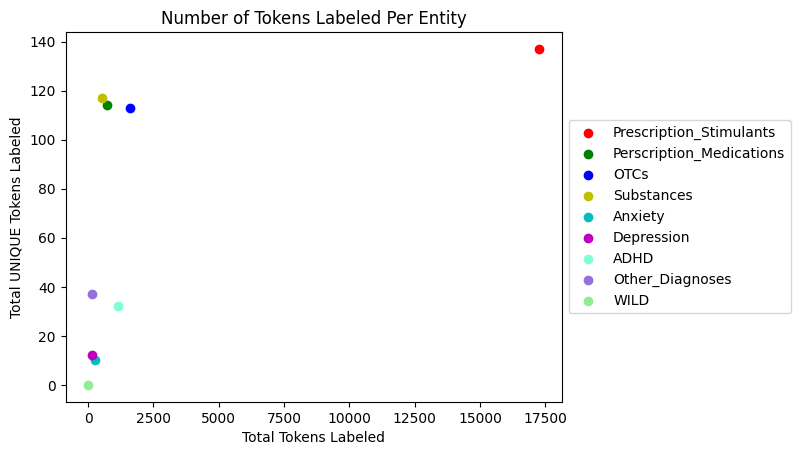

In [ ]:
categories = counts['entity'].unique()
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'aquamarine', 'mediumpurple', 'lightgreen']  # You can extend this list for more categories
for i, category in enumerate(categories):
  plt.scatter(counts[counts['entity'] == category]['Total_Tokens'], counts[counts['entity'] == category]['Total_UNIQUE_Tokens'], label=category, color=colors[i])
plt.xlabel('Total Tokens Labeled')
plt.ylabel('Total UNIQUE Tokens Labeled')
plt.title('Number of Tokens Labeled Per Entity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.grid(True)
plt.savefig(out_dir+'plots/entity_tokens.png')
plt.show()

Get only the unique labels in each set...

In [ ]:
gold_labels_set = []
for labels in gold_labels:
  uniq = set(labels)
  gold_labels_set.append(list(uniq))

test_labels_set = []
for labels in test_labels:
  uniq = set(labels)
  test_labels_set.append(list(uniq))

In [ ]:
id_to_classes

{0: 'Prescription_Stimulants',
 1: 'Perscription_Medications',
 2: 'OTCs',
 3: 'Substances',
 4: 'Anxiety',
 5: 'Depression',
 6: 'ADHD',
 7: 'Other_Diagnoses',
 8: 'WILD'}

In [ ]:
test_labels_set[10]

[8, 0, 3, 6]

In [ ]:
classes_to_id['Prescription_Stimulants']

0

**CALCULATE ONE ENTITY AT A TIME...**

In [ ]:
entity = 'Prescription_Stimulants'
fp, tp, fn, tn = 0, 0, 0, 0

for i in range(0,len(test_labels_set)): # loops through all 401 posts
  in_test = classes_to_id[entity] in test_labels_set[i]
  in_gold = classes_to_id[entity] in gold_labels_set[i]

  if in_test==False and in_gold==True: # is true but predicted false (FN)
    fn = fn+1
  elif in_test==True and in_gold==False: # is false but predicted true (FP)
    fp = fp+1
  elif in_test==False and in_gold==False: # true negative
    tn = tn+1
  elif in_test==True and in_gold==True: # true positive
    tp = tp+1

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")


True Positives: 312
False Positives: 71
True Negatives: 12
False Negatives: 6


**FINAL METHOD USED...**

In [ ]:
# convert list of lists to numpy arrays for easier manipulation
gold_array = np.array(gold_labels)
test_array = np.array(test_labels)

In [ ]:
# flatten arrays to get single list of predictions for all samples
gold_flat = gold_array.flatten()
test_flat = test_array.flatten()

In [ ]:
accuracy = accuracy_score(gold_flat, test_flat) # calculate accuracy

precision = precision_score(gold_flat, test_flat, average='weighted')
recall = recall_score(gold_flat, test_flat, average='weighted')
f1 = f1_score(gold_flat, test_flat, average='weighted')

In [ ]:
from sklearn.metrics import classification_report

classification_report(gold_flat, test_flat)

'              precision    recall  f1-score   support\n\n           0       0.10      0.09      0.10      3278\n           1       0.18      0.40      0.24       112\n           2       0.12      0.75      0.20        56\n           3       0.11      0.76      0.19        80\n           4       0.36      0.14      0.20        36\n           5       0.62      0.83      0.71        36\n           6       0.00      0.04      0.00       136\n           7       0.04      0.44      0.07        25\n           8       0.99      0.96      0.97    244861\n\n    accuracy                           0.95    248620\n   macro avg       0.28      0.49      0.30    248620\nweighted avg       0.97      0.95      0.96    248620\n'

In [ ]:
# Compute overall accuracy
overall_accuracy = accuracy_score(gold_flat, test_flat)

# Compute accuracy for each class
class_accuracies = {}
for class_label in range(N_LABELS):
    # Extract indices corresponding to the current class
    indices = [i for i, label in enumerate(gold_flat) if label == class_label]

    # Extract true labels and predicted labels for the current class
    class_y_true = [gold_flat[i] for i in indices]
    class_y_pred = [test_flat[i] for i in indices]

    # Compute accuracy for the current class
    class_accuracy = accuracy_score(class_y_true, class_y_pred)

    # Store the accuracy for the current class
    class_accuracies[class_label] = class_accuracy

# Print overall accuracy and class-wise accuracies
print("Overall Accuracy:", overall_accuracy)
print("Class-wise Accuracies:")
for class_label, accuracy in class_accuracies.items():
    print(f"Class {class_label}: {accuracy}")

Overall Accuracy: 0.9509532620062746
Class-wise Accuracies:
Class 0: 0.09426479560707748
Class 1: 0.4017857142857143
Class 2: 0.75
Class 3: 0.7625
Class 4: 0.1388888888888889
Class 5: 0.8333333333333334
Class 6: 0.03676470588235294
Class 7: 0.44
Class 8: 0.9634772381065175


In [ ]:
gold_binarized = np.eye(9)[gold_flat]


In [ ]:
# Calculate AUROC and AUPRC
# Binarize multiclass predictions because AUROC and AUPRC require binary classification!!!
# One-vs-Rest strategy can be used here

# np.eye creates a matrix of zeros (except for the diagonal=1) with 26 rows
# each row represents a different entity
gold_binarized = np.eye(9)[gold_flat]  # One-hot encode the true labels
test_scores = np.eye(9)[test_flat]  # One-hot encode the predicted labels
roc_auc = roc_auc_score(gold_binarized, test_scores, average='macro', multi_class='ovr')
auprc = average_precision_score(gold_binarized, test_scores, average='macro')

(17936/1070400)*100 = 16.75% of all tokens are labeled with an entity!!!

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUROC:", roc_auc)
print("AUPRC:", auprc)

Accuracy: 0.9509532620062746
Precision: 0.9731228548911792
Recall: 0.9509532620062746
F1-score: 0.9617172151645983
AUROC: 0.6957605022598817
AUPRC: 0.20387086834617385


In [ ]:
gold_flat

array([25, 25, 25, ..., 25, 25, 25])

In [ ]:
test_scores[4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.])